In [1]:
import os
import mxnet as mx
import numpy as np
import pandas as pd
from pandas import DataFrame
from gluonts.model.predictor import Predictor
from pathlib import Path
from gluonts.model.forecast import SampleForecast
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import re
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.graph_objs._figure import Figure
import plotly.io as pio
from typing import List, Optional
from gluonts.mx.model.predictor import RepresentableBlockPredictor

from plotly.subplots import make_subplots

# Evaluation and plot function 

In [2]:
def creat_test_data(df_input: DataFrame,
                    start_time: str,
                    end_time: str,
                    step,
                    target_var: str,
                    covariate: List[str],
                    zero_time: str = None,
                    feat_static_cat: List[int] = None,
                    show: bool = True) -> List[dict]:
    Data = []
    if zero_time == None:
        zero_time = df_input.index[0]
    # print(zero_time)
    zero_idx = df_input.index.get_loc(zero_time)
    start_idx = df_input.index.get_loc(start_time)
    end_idx = df_input.index.get_loc(end_time)
    idx = start_idx

    while idx <= min(end_idx, df_input.shape[0]):
        d = {
            "start": zero_time,
            "target": df_input[zero_idx:idx + 1][target_var]
        }
        if feat_static_cat != None:
            d['feat_static_cat'] = feat_static_cat
        if len(covariate) != 0:
            d["feat_dynamic_real"] = df_input[zero_idx:idx +
                                              1][covariate].T.values
        Data.append(d)
        idx += step

    # show some data
    if show:
        print(f'create {len(Data)} test_data')
        print('The 1st test_data:\n', Data[0])
        print('The -1st test_data:\n', Data[-1])
    return Data

def results_n_to_1(tss: List[DataFrame],
                   forecasts: List[SampleForecast],
                   quantile: float = None) -> tuple:

    Tss, Forecasts = [], []
    for ts_it, forecast_it in zip(tss, forecasts):
        Tss.append(ts_it.loc[forecast_it.index])
        if quantile == None:
            Forecasts.append(forecast_it.mean_ts)
        else:
            Forecasts.append(forecast_it.quantile_ts(quantile))
    return (pd.concat(Tss), pd.DataFrame(pd.concat(Forecasts)))


def Alarm_rate(tss: List[DataFrame],
               forecasts: List[SampleForecast],
               CI: Optional[float] = None,
               alarm_value: Optional[float] = 1000) -> int:

    if CI != None:
        alpha = (1 - CI / 100) / 2
        Tss, Forecasts_low = results_n_to_1(tss, forecasts, quantile=alpha)
        Tss, Forecasts_up = results_n_to_1(tss, forecasts, quantile=1 - alpha)
        return ((Tss[0] <= Forecasts_low[0]) |
                (Tss[0] >= Forecasts_up[0])).mean()

    else:
        Tss, Forecasts = results_n_to_1(tss, forecasts, quantile=0.5)
        return np.array(np.abs(Tss[0] - Forecasts[0]) >= alarm_value).mean()


# prediction function
def Predict_model(df: DataFrame, target_var: List[str], covariate: List[str],
                  predictor: RepresentableBlockPredictor, Predict_unknow: bool,
                  resample_mode: str, test_period: Optional[dict],
                  feat_static_cat: List[int], min_wc: float,
                  test_zero_time: Optional[str], show_test_data: bool,
                  r_seed: int, num_samples: int, CI: List[float],
                  alarm_value: float, seasonality: Optional[float],
                  quantiles: List[float]):

    freq = predictor.freq

    # resample
    if resample_mode == 'mean':
        df_input = df.resample(rule=freq).mean()
    if resample_mode == 'first':
        df_input = df.resample(rule=freq).first()
    if resample_mode == 'last':
        df_input = df.resample(rule=freq).last()

    df_input_01 = (df_input - df_input.min()) / (df_input.max() -
                                                 df_input.min())
    # print(df_input_01)

    # create test dataset
    prediction_length = predictor.prediction_length

    # The last known row of data is used to supplement 
    # the future data in order to predict the unknown value


    N = prediction_length + 1
    supplement_idx = pd.date_range(df_input_01.index[-1],
                                   periods=N + 1,
                                   freq=freq)[1:]
    supplement = pd.DataFrame(pd.concat([df_input_01[-1:]] * N).values,
                              index=supplement_idx,
                              columns=df_input_01.columns)
    # print(supplement)
    df_input_01 = df_input_01.append(supplement)

    if test_period != None:
        start_time = test_period['start']
        end_time = test_period['end']

    if Predict_unknow:
        # print(df_input_01)
        start_time = df_input_01.index[-2]
        print(start_time)
        end_time = df_input_01.index[-1]

    test_data = ListDataset(creat_test_data(df_input=df_input_01,
                                            start_time=start_time,
                                            end_time=end_time,
                                            step=prediction_length,
                                            target_var=target_var,
                                            covariate=covariate,
                                            zero_time=test_zero_time,
                                            feat_static_cat=feat_static_cat,
                                            show=show_test_data),
                            freq=freq)
    # Set random numbers to stabilize the prediction results
    if r_seed is not None:
        mx.random.seed(r_seed)
        np.random.seed(r_seed)

    # The predicted value is prefixed with forecast, and the actual value is prefixed with tss

    forecast_it, ts_it = make_evaluation_predictions(dataset=test_data,
                                                     predictor=predictor,
                                                     num_samples=num_samples)

    # The prediction results of DeepAR model are normalized data
    # Normalized observations: tss_ 01, normalized prediction: forecast_ 01

    forecasts_01, tss_01 = list(forecast_it), list(ts_it)

    scale = df_input[target_var].max() - df_input[target_var].min()
    bias = df_input[target_var].min()

    # Original observations: tss， Original predictions: forecasts
    # shifted observations: tss_offset,  shifted predictions: forecasts_offset
    forecasts, tss, forecasts_offset, tss_offset = [], [], [], []
    for f, t in zip(forecasts_01, tss_01):
        # The normalized data is converted to the original data
        tss.append(t * scale + bias)
        forecasts.append(
            SampleForecast(samples=f.samples * scale + bias,
                           start_date=f.start_date,
                           freq=f.freq))
        
        # shift the data so that the minimum target value is min_ wc
        tss_offset.append(t * scale + min_wc)
        forecasts_offset.append(
            SampleForecast(samples=f.samples * scale + min_wc,
                           start_date=f.start_date,
                           freq=f.freq))
    print(f'before shift the minimum of {target_var} water consumption is', bias)
    print(f'after shift {min_wc - bias}, the minimum of {target_var} water consumption is', min_wc)

    # Predict known sequences for evaluation
    if not Predict_unknow:
        Error, Item_metrics = [], []
        for (f, t) in ((forecasts_01, tss_01), (forecasts, tss),
                       (forecasts_offset, tss_offset)):
            (error, item_metrics) = Eval_Result(forecasts=f,
                                                tss=t,
                                                alarm_value=alarm_value,
                                                CI=CI,
                                                seasonality=seasonality,
                                                quantiles=quantiles)
            scale = 1
            Error.append(error)
            Item_metrics.append(item_metrics)
        Error = pd.DataFrame(Error,
                             columns=['RMSE', 'MAPE', f'AR_{alarm_value}'] +
                             ['ARCI_' + str(ci) for ci in CI],
                             index=['Normalized_evaluation', 'evaluation', 'shifted_evaluation'])
        return (forecasts, tss, Error, Item_metrics)
    return (forecasts, tss, None, None)


# Evaluation funciton
# observations: tss, predictions: forecasts
def Eval_Result(forecasts: SampleForecast, tss: List[DataFrame],
                alarm_value: float, CI: List[float], seasonality: float,
                quantiles: List[float]) -> (dict, dict):

    evaluator = Evaluator(quantiles=quantiles, seasonality=seasonality)
    agg_metrics, item_metrics = evaluator(iter(tss),
                                          iter(forecasts),
                                          num_series=len(tss))
    error = []
    error.append(agg_metrics['RMSE'])
    error.append(agg_metrics['MAPE'])
    error.append(Alarm_rate(tss, forecasts, alarm_value=alarm_value))
    error.extend([Alarm_rate(tss, forecasts, CI=ci) for ci in CI])

    return (error, item_metrics)


def Split_train_valid_test(df, ratio):
    (r, _) = df.shape
    train_period = {
        'start': [df.index[0]],
        'end': [df.index[int(r * ratio[0])]]
    }
    validate_period = {
        'start': [df.index[int(r * ratio[0])]],
        'end': [df.index[int(r * (ratio[0] + ratio[1]))]]
    }
    test_period = {
        'start': [df.index[int(r * (ratio[0] + ratio[1]))]],
        'end': [df.index[-1]]
    }
    return train_period, validate_period, test_period

# change color palette
def alpha_for_percentile(p):  
    return (0.8 * p / 100.0)**0.35


def map_alarm_points_to_color(tss: List[DataFrame],
                              forecasts: List[SampleForecast],
                              CI: float = None,
                              alarm_value: float = None) -> List[str]:

    marker_color = []
    Tss, Forecasts = results_n_to_1(tss, forecasts, quantile=0.5)
    if alarm_value != None:
        delta = np.array(np.abs(Tss[0] - Forecasts[0]) >= alarm_value)
        for d in delta:
            if d:
                marker_color.append('rgba(225,0,0,0.6)')
            else:
                marker_color.append('rgba(0,100,0,0.1)')
    if CI != None:
        alpha = (1 - CI / 100) / 2
        Tss, Forecasts_low = results_n_to_1(tss, forecasts, quantile=alpha)
        Tss, Forecasts_up = results_n_to_1(tss, forecasts, quantile=1 - alpha)
        for (t, fl, fu) in zip(Tss[0], Forecasts_low[0], Forecasts_up[0]):
            if t < fl or t > fu:
                marker_color.append('rgba(225,0,0,0.4)')
            else:
                marker_color.append('rgba(0,100,0,0.05)')
    return marker_color


def plot_pre_known(station_name: str,
                   tss: List[DataFrame],
                   forecasts: List[SampleForecast],
                   Error: DataFrame,
                   CI: List[float],
                   alarm_value: float,
                   df_c: DataFrame = None) -> Figure:

    fig = make_subplots(rows=5,
                        cols=1,
                        row_heights=[0.45, 0.1, 0.15, 0.15, 0.15],
                        shared_xaxes=False,
                        vertical_spacing=0.05,
                        specs=[[{
                            "type": "scatter"
                        }], [{
                            "type": "table"
                        }], [{
                            "type": "table"
                        }], [{
                            "type": "scatter"
                        }], [{
                            "type": "histogram"
                        }]],
                        subplot_titles=("", "Evaluation", "Data Table", 'Residual = observed value - predicted value',
                                        'Cumulative percentage of average absolute percentage error MAPE'))

    Tss, Forecasts = results_n_to_1(tss, forecasts, quantile=0.5)
    start_time = Tss.index[0]
    end_time = Tss.index[-1]

    # Plot observations
    fig.add_traces(go.Scatter(x=Tss.index,
                              y=Tss[0],
                              line=dict(color='black'),
                              name='Observations',
                              showlegend=True),
                   rows=1,
                   cols=1)

    # Plot prediction (median)
    marker_color = map_alarm_points_to_color(tss,
                                             forecasts,
                                             alarm_value=alarm_value)
    fig.add_traces(go.Scatter(x=Forecasts.index,
                              y=Forecasts[0],
                              line=dict(color='green'),
                              name='prediction(median)',
                              mode='lines+markers',
                              marker_color=marker_color,
                              showlegend=True),
                   rows=1,
                   cols=1)

    # The strip chart is drawn according to the confidence interval
    ps = [50.0] + [50.0 + f * c / 2.0 for c in CI for f in [-1.0, +1.0]]
    percentiles_sorted = sorted(set(ps))
    band_num = len(percentiles_sorted) // 2
    for i in range(band_num):
        ptile = percentiles_sorted[i]
        alpha = str(alpha_for_percentile(ptile))
        color = f'rgba(0,100,0,{alpha})'
        name = str(100 - 2 * ptile) + f'% {band_num-i}σ confidence interval'

        Tss, Forecasts_low = results_n_to_1(tss,
                                            forecasts,
                                            quantile=ptile / 100)
        fig.add_traces(go.Scatter(x=Forecasts_low.index,
                                  y=Forecasts_low[0],
                                  line=dict(color='rgba(0, 100, 0, 0)'),
                                  legendgroup=f"group_band_{i}",
                                  name=name,
                                  showlegend=False),
                       rows=1,
                       cols=1)
        Tss, Forecasts_up = results_n_to_1(tss,
                                           forecasts,
                                           quantile=(1 - ptile / 100))
        fig.add_traces(go.Scatter(x=Forecasts_up.index,
                                  y=Forecasts_up[0],
                                  line=dict(color='rgba(0, 100, 0, 0)'),
                                  legendgroup=f"group_band{i}",
                                  name=name,
                                  fill='tonexty',
                                  fillcolor=color,
                                  showlegend=True),
                       rows=1,
                       cols=1)
        if i == 0:
            Forecasts_3σ_low = Forecasts_low
            Forecasts_3σ_up = Forecasts_up

    # Plot ±alarm_value prediction interval
    fig.add_traces(go.Scatter(x=Forecasts.index,
                              y=Forecasts[0] + alarm_value,
                              line=dict(color='rgba(100, 0, 0, 0)'),
                              legendgroup="alarm_band",
                              name=f'±{alarm_value} prediction interval',
                              showlegend=False),
                   rows=1,
                   cols=1)
    fig.add_traces(go.Scatter(x=Forecasts.index,
                              y=Forecasts[0] - alarm_value,
                              line=dict(color='rgba(100, 0, 0, 0)'),
                              legendgroup="alarm_band",
                              name=f'±{alarm_value} prediction interval',
                              fill='tonexty',
                              fillcolor='rgba(100, 0, 0, 0.2)',
                              showlegend=True),
                   rows=1,
                   cols=1)

    # Plot pipe bursts time if the info is provided
    # Diameter of water pipe burst:  1(red): >=1000 ; 2(red): <1000
    fillcolor = ["blue", "yellow"]
    if df_c is not None:
        for idx in range(df_c.shape[0]):
            x0 = pd.Timestamp(df_c['start time'][idx])
            x1 = pd.Timestamp(df_c['end time'][idx])
            if x0 >= start_time and x1 <= end_time:
                fig.add_vrect(
                    x0=x0,
                    x1=x1,
                    annotation_text=str(idx),
                    fillcolor=fillcolor[df_c['Diameter'][idx] - 1],
                    opacity=0.2,
                    line_width=0.5,
                    row=1,
                    col=1,
                    name='D >= 1000')

    fig.update_xaxes(title_text='', row=1, col=1)
    fig.update_yaxes(title_text='Water Consumption', row=1, col=1)
    
    # Add evaluation table
    # ['Normalized_evaluation', 'evaluation', 'shifted_evaluation']
    rmse = round(Error.loc['evaluation', 'RMSE'], 2)
    mape = round(Error.loc['evaluation', 'MAPE'] * 100, 2)
    if min(Tss[0]) <= 0:
        mape = round(Error.loc['shifted_evaluation', 'MAPE'] * 100, 2)
    ar = round(Error.loc['evaluation', f'AR_{alarm_value}'] * 100, 2)
    arq_2σ = round(Error.loc['evaluation', f'ARCI_{CI[-2]}'] * 100, 2)
    arq_3σ = round(Error.loc['evaluation', f'ARCI_{CI[-1]}'] * 100, 2)

    fig.add_traces(go.Table(header=dict(values=[
        "RMSE", "MAPE", f"% of more than ±{alarm_value}",
        "% of more than ±2σ interval", "% of more than ±3σ interval"
    ],
                                        font=dict(size=20),
                                        align="center"),
                            cells=dict(values=[
                                f'{rmse}', f'{mape}%', f'{ar}%', f'{arq_2σ}%',
                                f'{arq_3σ}%'
                            ],
                                       font=dict(size=20),
                                       align="center",
                                       height=30)),
                   rows=2,
                   cols=1)

    # Add data table
    fill_color = map_alarm_points_to_color(tss, forecasts, CI=CI[-1])
    fig.add_trace(go.Table(
        header=dict(values=['Time', 'Observations', 'Predictions', 'Residuals', 'μ - 3σ', 'μ + 3σ'],
                    font=dict(size=20),
                    align="center"),
        cells=dict(values=[[str(idx) for idx in Forecasts.index],
                           [int(t) for t in Tss[0]],
                           [int(f) for f in Forecasts[0]],
                           [int(f) for f in Tss[0] - Forecasts[0]],
                           [int(f) for f in Forecasts_3σ_low[0]],
                           [int(f) for f in Forecasts_3σ_up[0]]],
                   fill_color=[fill_color * 6],
                   align="center",
                   height=30)),
                  row=3,
                  col=1)

    # Plot Residual
    fig.add_traces(go.Scatter(x=Forecasts.index,
                              y=Tss[0] - Forecasts[0],
                              name='Residuals',
                              mode='markers',
                              marker_color=marker_color,
                              showlegend=False),
                   rows=4,
                   cols=1)
    fig.update_xaxes(title_text='', title_standoff=10, row=4, col=1)
    fig.update_yaxes(title_text='△Water Consumptions', row=4, col=1)

    # Plot CDF
    delta = np.abs(Tss[0] - Forecasts[0]) / np.abs(Tss[0]) * 100
    if min(Tss[0]) <= 0:
        delta = np.abs(Tss[0] - Forecasts[0]) / (Tss[0]-min(Tss[0])+500) * 100
    fig.add_traces(go.Histogram(x=delta,
                                histnorm='probability density',
                                opacity=0.2,
                                cumulative_enabled=True,
                                showlegend=False),
                   rows=5,
                   cols=1)
    fig.update_xaxes(title_text='MAPE(%)',
                     title_standoff=10,
                      # range = [0,100],
                     row=5,
                     col=1)
    fig.update_yaxes(title_text='cumulative （%）', row=5, col=1)
    
    # adjust font size
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=20, color='black')
        
    # adjust title, axis,layout
    fig.update_layout(
        title=dict(
            text=f"{station_name} Water Consumption Prediction:{str(start_time)}~{str(end_time)}",
            x=0.5,
            y=0.98,
            font=dict(size=30)),
        font=dict(size=20),
        width=2000,
        height=2200,
        margin=dict(l=40, r=40, t=80, b=80),
        paper_bgcolor="LightSteelBlue")

    return fig


def plot_pre_unknown(station_name: str, tss: List[DataFrame],
                     forecasts: List[SampleForecast], CI: List[float],
                     alarm_value: float) -> Figure:

    # Ifshowlegend = True

    fig = go.Figure()
    fig = make_subplots(rows=2,
                        cols=1,
                        row_heights=[0.7, 0.3],
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        specs=[[{
                            "type": "scatter"
                        }], [{
                            "type": "table"
                        }]])

    # Plot median as prediction
    Tss, Forecasts = results_n_to_1(tss, forecasts, quantile=0.5)
    
    # Plot  ±alarm_value
    fig.add_traces(go.Scatter(x=Forecasts.index,
                              y=Forecasts[0],
                              line=dict(color='green'),
                              name='Prediction(median)',
                              mode='lines+markers',
                              showlegend=True),
                   rows=1,
                   cols=1)


    # plot ±σ
    ps = [50.0] + [50.0 + f * c / 2.0 for c in CI for f in [-1.0, +1.0]]
    percentiles_sorted = sorted(set(ps))
    band_num = len(percentiles_sorted) // 2
    for i in range(band_num):
        ptile = percentiles_sorted[i]
        alpha = str(alpha_for_percentile(ptile))
        color = f'rgba(0,100,0,{alpha})'
        name = str(100 - 2 * ptile) + f'% {band_num-i}σ confidence interval'

        Tss, Forecasts_low = results_n_to_1(tss,
                                            forecasts,
                                            quantile=ptile / 100)

        fig.add_traces(go.Scatter(x=Forecasts_low.index,
                                  y=Forecasts_low[0],
                                  line=dict(color='rgba(0, 100, 0, 0)'),
                                  legendgroup=f"group_band_{i}",
                                  name=name,
                                  showlegend=False),
                       rows=1,
                       cols=1)

        Tss, Forecasts_up = results_n_to_1(tss,
                                           forecasts,
                                           quantile=(1 - ptile / 100))

        fig.add_traces(go.Scatter(x=Forecasts_up.index,
                                  y=Forecasts_up[0],
                                  line=dict(color='rgba(0, 100, 0, 0)'),
                                  legendgroup=f"group_band{i}",
                                  name=name,
                                  fill='tonexty',
                                  fillcolor=color,
                                  showlegend=True),
                       rows=1,
                       cols=1)
        if i == 0:
            Forecasts_3σ_low = Forecasts_low
            Forecasts_3σ_up = Forecasts_up

    fig.add_traces(
        go.Scatter(
            x=Forecasts.index,
            y=Forecasts[0] + alarm_value,
            line=dict(color='rgba(100, 0, 0, 0)'),
            legendgroup="alarm_band",
            # fill='tonexty',
            name=f'±{alarm_value}prediction interval',
            showlegend=False),
        rows=1,
        cols=1)

    fig.add_traces(go.Scatter(x=Forecasts.index,
                              y=Forecasts[0] - alarm_value,
                              line=dict(color='rgba(100, 0, 0, 0)'),
                              legendgroup="alarm_band",
                              name=f'±{alarm_value}prediction interval',
                              fill='tonexty',
                              fillcolor='rgba(100, 0, 0, 0.2)',
                              showlegend=True),
                   rows=1,
                   cols=1)

    fig.add_trace(go.Table(
        header=dict(values=['Time', 'Observations(updating)', 'Predictions', 'μ-3σ', 'μ+3σ'],
                    font=dict(size=15),
                    align="center"),
        cells=dict(values=[[str(idx) for idx in Forecasts.index],
                           ['-' for _ in Forecasts.index],
                           [int(f) for f in Forecasts[0]],
                           [int(f) for f in Forecasts_3σ_low[0]],
                           [int(f) for f in Forecasts_3σ_up[0]]],
                   align="center")),
                  row=2,
                  col=1)

    fig.update_layout(
        title=dict(
            text=
            f"{station_name} Water Consumption Prediction:{str(Forecasts.index[0])}~{str(Forecasts.index[-1])}",
            x=0.5,
            y=0.98,
            font=dict(size=30)),
        xaxis_title='Time',
        yaxis_title="Water Consumption",
        # autosize=True,
        font=dict(size=15),
        width=2000,
        height=1000,
        margin=dict(l=70, r=20, t=100, b=20),
        paper_bgcolor="LightSteelBlue")

    return fig


def main(
    station: str,
    covariate: List[str],
    Predict_unknow: bool,
    predictor_path: RepresentableBlockPredictor,
    resample_mode: str = 'mean',
    test_period: dict = None,
    test_zero_time: str = None,
    show_test_data: bool = True,
    num_samples: int = 100,
    min_wc: float = 500,
    alarm_value: float = 1000,
    r_seed: int = 0,
    CI: List[float] = [68.27, 95.45, 99.73],
    quantiles: List[float] = [0.8, 0.9],
    seasonality: float = 1,
    plot: bool = False,
) -> tuple:

    
    # If the water consumption has a negative value, 
    # it is necessary to offset the whole to ensure that
    # the minimum water consumption is min_ wc

    Feat_Static_Cat_Path = 'feat_static_cat.xlsx'
    cx = {'HY': 'HY_bursts.xlsx', 'WJ': None}
    PATH_1 = 'clean data'
    Features_Path = 'new features.csv'


    # The prediction model may need static categories to 
    # distinguish Hanyang station from Wujing station

    feat_static_cat = pd.read_excel(Feat_Static_Cat_Path, header=0)
    station_name = feat_static_cat[feat_static_cat.loc[:, 'Short'] ==
                                   station]['Station'].values[0]
    feat_static_cat = [
        feat_static_cat.index[feat_static_cat['Short'] == station].values[0]
    ]
    # df_c : station pipe burst data
    df_c = pd.read_excel(cx[station]) if cx[station] != None else None
    # df_wc : water consumption data
    df_wc = pd.read_csv(f'{PATH_1}\\{station}.csv', index_col=0)
    # idx : time index(pd.Timestamp)
    idx = pd.date_range(df_wc.index[0], periods=df_wc.shape[0], freq="T")
    # df_features : related features
    df_features = pd.read_csv(Features_Path, index_col=0)

    # Combine water consumption data with relevant features in one dataframe
    df = pd.DataFrame(np.hstack((np.array(df_wc), np.array(df_features))),
                      index=idx,
                      columns=np.append(df_wc.columns.values,
                                        df_features.columns.values))

    # load model
    predictor = Predictor.deserialize(Path(predictor_path))
    results = Predict_model(df=df,
                            target_var=station + '_Water_Consumption',
                            covariate=covariate,
                            predictor=predictor,
                            Predict_unknow=Predict_unknow,
                            resample_mode=resample_mode,
                            test_period=test_period,
                            feat_static_cat=feat_static_cat,
                            min_wc=min_wc,
                            test_zero_time=test_zero_time,
                            show_test_data=show_test_data,
                            r_seed=r_seed,
                            num_samples=num_samples,
                            CI=CI,
                            alarm_value=alarm_value,
                            seasonality=seasonality,
                            quantiles=quantiles)
    (forecasts, tss, Error, Item_metrics) = results

    fig = None
    if Predict_unknow and plot:
        fig = plot_pre_unknown(station_name=station_name,
                               tss=tss,
                               forecasts=forecasts,
                               CI=CI,
                               alarm_value=alarm_value)
    if not Predict_unknow and plot:
        fig = plot_pre_known(station_name=station_name,
                             tss=tss,
                             forecasts=forecasts,
                             Error=Error,
                             CI=CI,
                             alarm_value=alarm_value,
                             df_c=df_c)
    return (forecasts, tss, Error, Item_metrics, fig)

# HanYang Station testset evaluation

In [3]:
if __name__ == '__main__':

    # plotly in browser
    pio.renderers.default = 'browser'
    station = 'HY'
    covariate = ['HF_e1', 'MT']
#     model_name = '01_HY_HF_exponential_kernel_MT_Zd_try3'
    model_name = 'HY_predictor'
    Predict_unknow = False
    test_period = {'start': '2020-10-20 00:00', 'end': '2020-12-31 23:50'}
    predictor_path = f'DeepAR_Model/{model_name}'
    predict_paras = dict(predictor_path=predictor_path,
                         resample_mode='mean',
                         test_zero_time=None,
                         show_test_data=True,
                         num_samples=100,
                         min_wc=500)
    eval_paras = dict(alarm_value=1000,
                      r_seed=0,
                      CI=[68.27, 95.45, 99.73],
                      quantiles=[0.8, 0.9],
                      seasonality=1)
    results = main(station=station,
                   covariate=covariate,
                   Predict_unknow=Predict_unknow,
                   test_period=test_period,
                   plot=True,
                   **predict_paras,
                   **eval_paras)

    (forecasts, tss, Error, Item_metrics, fig) = results
    if not os.path.exists('Fig'):
        os.mkdir('Fig')
    fig.write_html(f'Fig\\{model_name}.html')

create 73 test_data
The 1st test_data:
 {'start': Timestamp('2019-01-01 00:00:00', freq='10T'), 'target': 2019-01-01 00:00:00    0.517288
2019-01-01 00:10:00    0.408513
2019-01-01 00:20:00    0.409429
2019-01-01 00:30:00    0.392337
2019-01-01 00:40:00    0.423605
                         ...   
2020-10-19 23:20:00    0.436328
2020-10-19 23:30:00    0.435876
2020-10-19 23:40:00    0.382113
2020-10-19 23:50:00    0.334611
2020-10-20 00:00:00    0.274254
Freq: 10T, Name: HY_Water_Consumption, Length: 94753, dtype: float64, 'feat_static_cat': [0], 'feat_dynamic_real': array([[4.65252001e-01, 4.65252001e-01, 4.65252001e-01, ...,
        1.22886258e-05, 1.22886258e-05, 4.52073278e-06],
       [1.89189189e-01, 1.89189189e-01, 1.89189189e-01, ...,
        5.67567568e-01, 5.67567568e-01, 5.94594595e-01]])}
The -1st test_data:
 {'start': Timestamp('2019-01-01 00:00:00', freq='10T'), 'target': 2019-01-01 00:00:00    0.517288
2019-01-01 00:10:00    0.408513
2019-01-01 00:20:00    0.409429
2019-0

Running evaluation:   0%|                                                                       | 0/73 [00:00<?, ?it/s]

before shift the minimum of HY_Water_Consumption water consumption is 2017.2
after shift -1517.2, the minimum of HY_Water_Consumption water consumption is 500


Running evaluation: 100%|█████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 276.45it/s]


In [4]:
print(Error.loc['evaluation'])

RMSE          429.852629
MAPE            0.052682
AR_1000         0.035674
ARCI_68.27      0.419711
ARCI_95.45      0.132135
ARCI_99.73      0.075438
Name: evaluation, dtype: float64


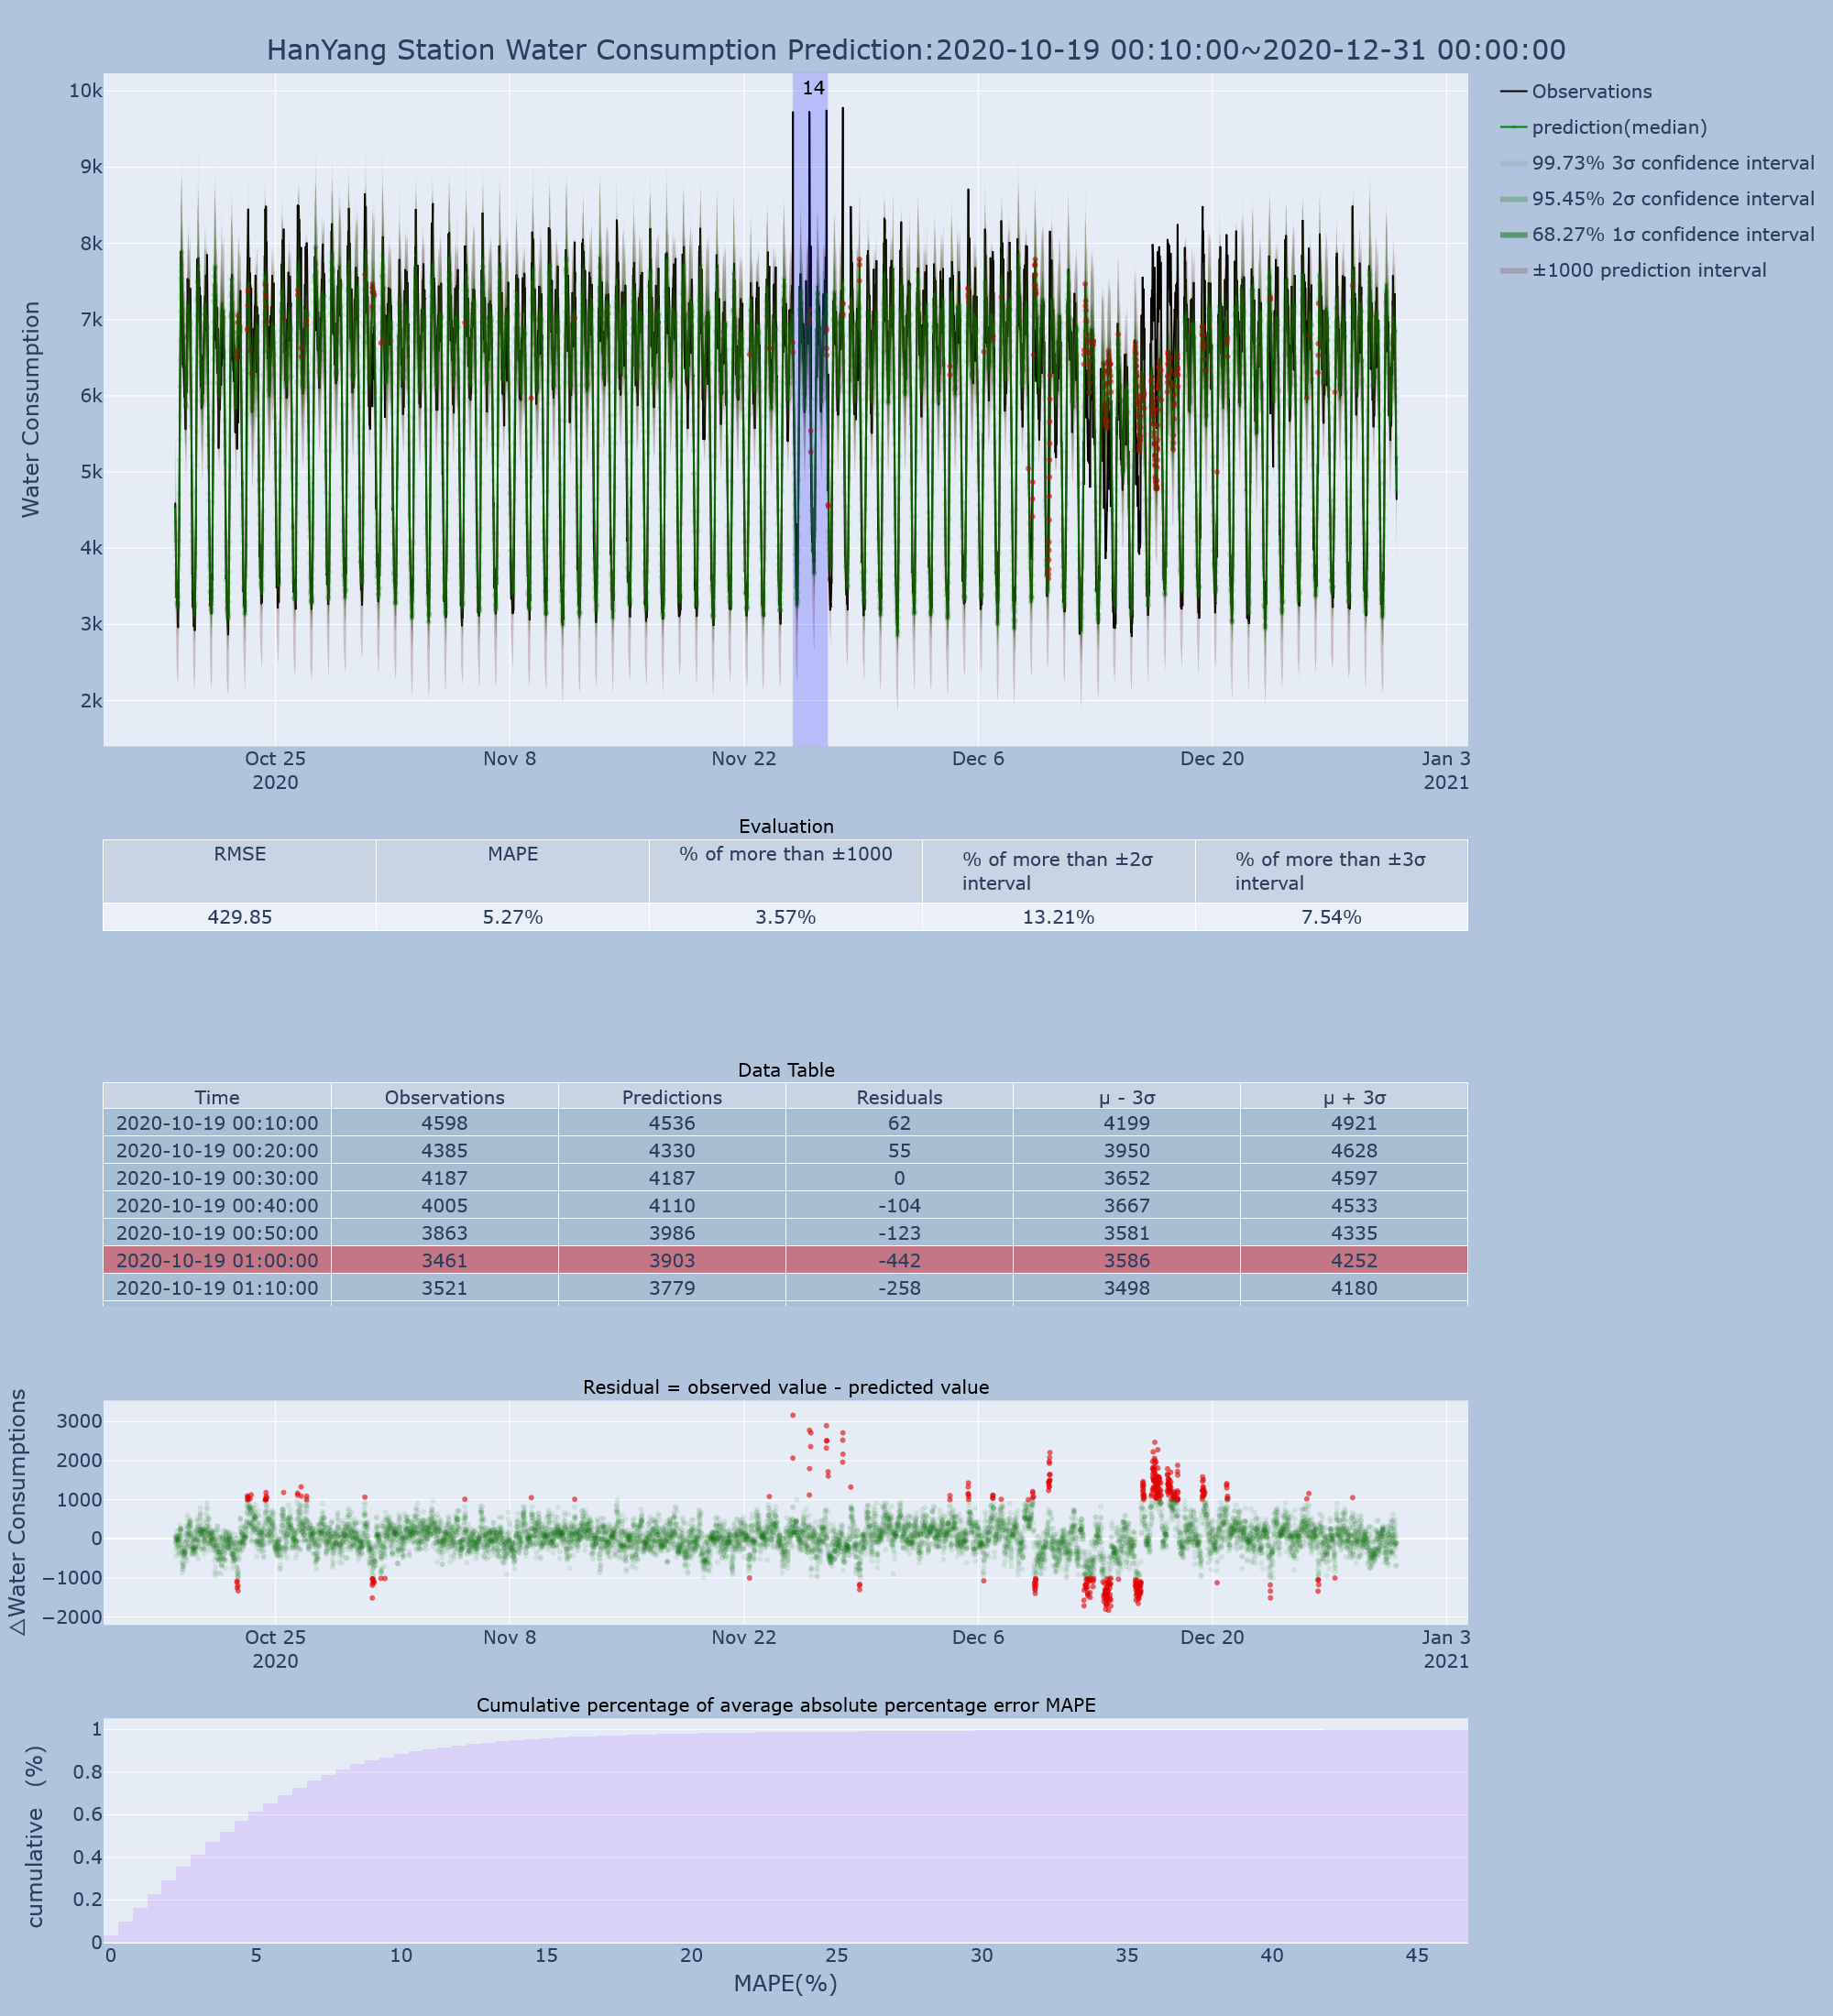

In [5]:
from IPython.display import Image
Image(filename=f'Fig\\{model_name}.png') 

# WuJin Station testset evaluation

In [6]:
if __name__ == '__main__':
    # plotly in browser
    pio.renderers.default = 'browser'
    station = 'WJ'
    covariate = ['HF_e1', 'MT']
#     model_name = '01_HY_WJ_HF_exponential_kernel_MT_Zd_try3'
    model_name = 'WJ_predictor'
    Predict_unknow = False
    test_period = {'start': '2020-10-20 00:00', 'end': '2020-12-31 23:50'}
    predictor_path = f'DeepAR_Model/{model_name}'
    predict_paras = dict(predictor_path=predictor_path,
                         resample_mode='mean',
                         test_zero_time=None,
                         show_test_data=True,
                         num_samples=100,
                         min_wc=500)
    eval_paras = dict(alarm_value=1000,
                      r_seed=0,
                      CI=[68.27, 95.45, 99.73],
                      quantiles=[0.8, 0.9],
                      seasonality=1)
    results = main(station=station,
                   covariate=covariate,
                   Predict_unknow=Predict_unknow,
                   test_period=test_period,
                   plot=True,
                   **predict_paras,
                   **eval_paras)

    (forecasts, tss, Error, Item_metrics, fig) = results
    if not os.path.exists('Fig'):
        os.mkdir('Fig')
    fig.write_html(f'Fig\\{model_name}.html')


create 73 test_data
The 1st test_data:
 {'start': Timestamp('2019-01-01 00:00:00', freq='10T'), 'target': 2019-01-01 00:00:00    0.487165
2019-01-01 00:10:00    0.455723
2019-01-01 00:20:00    0.452426
2019-01-01 00:30:00    0.447104
2019-01-01 00:40:00    0.447191
                         ...   
2020-10-19 23:20:00    0.597961
2020-10-19 23:30:00    0.425034
2020-10-19 23:40:00    0.359476
2020-10-19 23:50:00    0.325230
2020-10-20 00:00:00    0.258847
Freq: 10T, Name: WJ_Water_Consumption, Length: 94753, dtype: float64, 'feat_static_cat': [1], 'feat_dynamic_real': array([[4.65252001e-01, 4.65252001e-01, 4.65252001e-01, ...,
        1.22886258e-05, 1.22886258e-05, 4.52073278e-06],
       [1.89189189e-01, 1.89189189e-01, 1.89189189e-01, ...,
        5.67567568e-01, 5.67567568e-01, 5.94594595e-01]])}
The -1st test_data:
 {'start': Timestamp('2019-01-01 00:00:00', freq='10T'), 'target': 2019-01-01 00:00:00    0.487165
2019-01-01 00:10:00    0.455723
2019-01-01 00:20:00    0.452426
2019-0

Running evaluation:   0%|                                                                       | 0/73 [00:00<?, ?it/s]

before shift the minimum of WJ_Water_Consumption water consumption is -2677.2
after shift 3177.2, the minimum of WJ_Water_Consumption water consumption is 500


Running evaluation: 100%|█████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 291.93it/s]


In [7]:
    print(Error.loc['shifted_evaluation'])

RMSE          330.807795
MAPE            0.059928
AR_1000         0.013223
ARCI_68.27      0.339422
ARCI_95.45      0.095510
ARCI_99.73      0.048706
Name: shifted_evaluation, dtype: float64


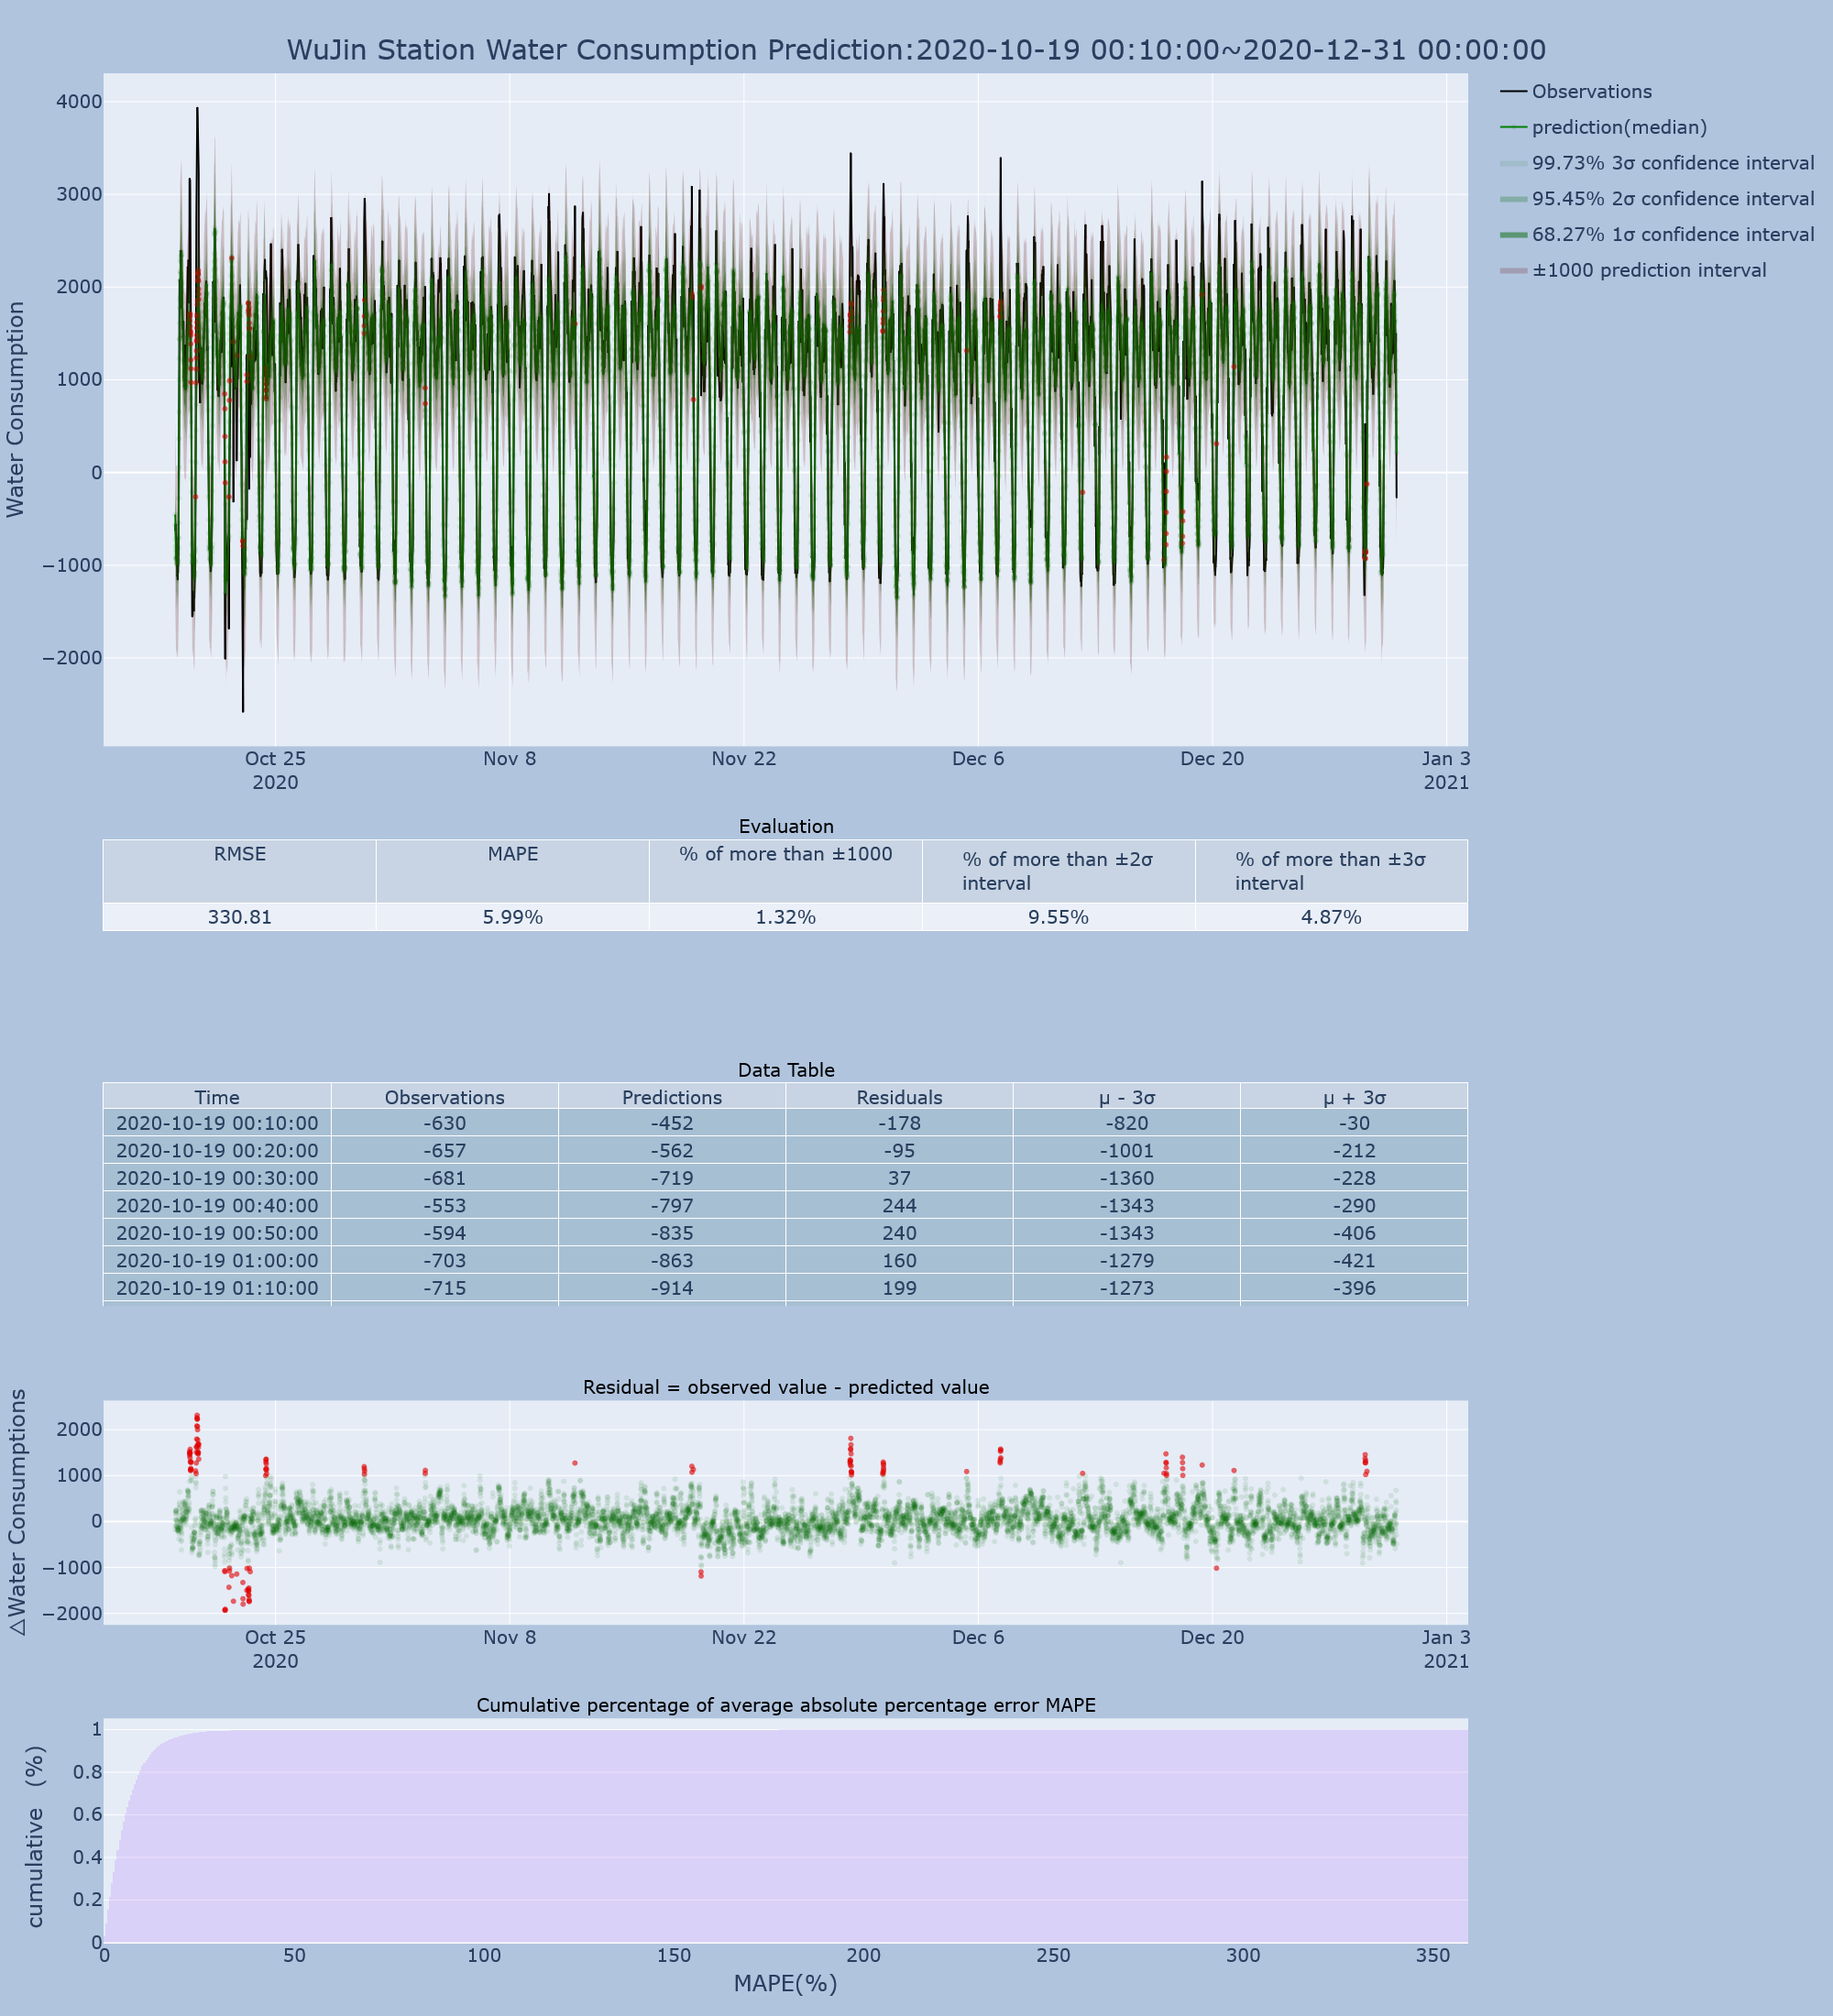

In [8]:
from IPython.display import Image
Image(filename=f'Fig\\{model_name}.png') 

# Predict unknow data (e.g. HanYang Station)

In [9]:
if __name__ == '__main__':

    # plotly in browser
    pio.renderers.default = 'browser'
    station = 'HY'
    covariate = ['HF_e1', 'MT']
#     model_name = '01_HY_HF_exponential_kernel_MT_Zd_try3'
    model_name = 'HY_predictor'
    Predict_unknow = True
    test_period = {'start': '2020-10-20 00:00', 'end': '2021-01-02 23:50'}
    predictor_path = f'DeepAR_Model/{model_name}'
    predict_paras = dict(predictor_path=predictor_path,
                         resample_mode='mean',
                         test_zero_time=None,
                         show_test_data=True,
                         num_samples=100,
                         min_wc=500)
    eval_paras = dict(alarm_value=1000,
                      r_seed=0,
                      CI=[68.27, 95.45, 99.73],
                      quantiles=[0.8, 0.9],
                      seasonality=1)
    results = main(station=station,
                   covariate=covariate,
                   Predict_unknow=Predict_unknow,
                   test_period=test_period,
                   plot=True,
                   **predict_paras,
                   **eval_paras)

    (forecasts, tss, Error, Item_metrics, fig) = results
    if not os.path.exists('Fig'):
        os.mkdir('Fig')
    fig.write_html(f'Fig\\{model_name}_unknown.html')


2021-01-01 23:50:00
create 1 test_data
The 1st test_data:
 {'start': Timestamp('2019-01-01 00:00:00', freq='10T'), 'target': 2019-01-01 00:00:00    0.517288
2019-01-01 00:10:00    0.408513
2019-01-01 00:20:00    0.409429
2019-01-01 00:30:00    0.392337
2019-01-01 00:40:00    0.423605
                         ...   
2021-01-01 23:10:00    0.352583
2021-01-01 23:20:00    0.352583
2021-01-01 23:30:00    0.352583
2021-01-01 23:40:00    0.352583
2021-01-01 23:50:00    0.352583
Freq: 10T, Name: HY_Water_Consumption, Length: 105408, dtype: float64, 'feat_static_cat': [0], 'feat_dynamic_real': array([[0.465252  , 0.465252  , 0.465252  , ..., 0.        , 0.        ,
        0.        ],
       [0.18918919, 0.18918919, 0.18918919, ..., 0.02702703, 0.02702703,
        0.02702703]])}
The -1st test_data:
 {'start': Timestamp('2019-01-01 00:00:00', freq='10T'), 'target': 2019-01-01 00:00:00    0.517288
2019-01-01 00:10:00    0.408513
2019-01-01 00:20:00    0.409429
2019-01-01 00:30:00    0.392337
20

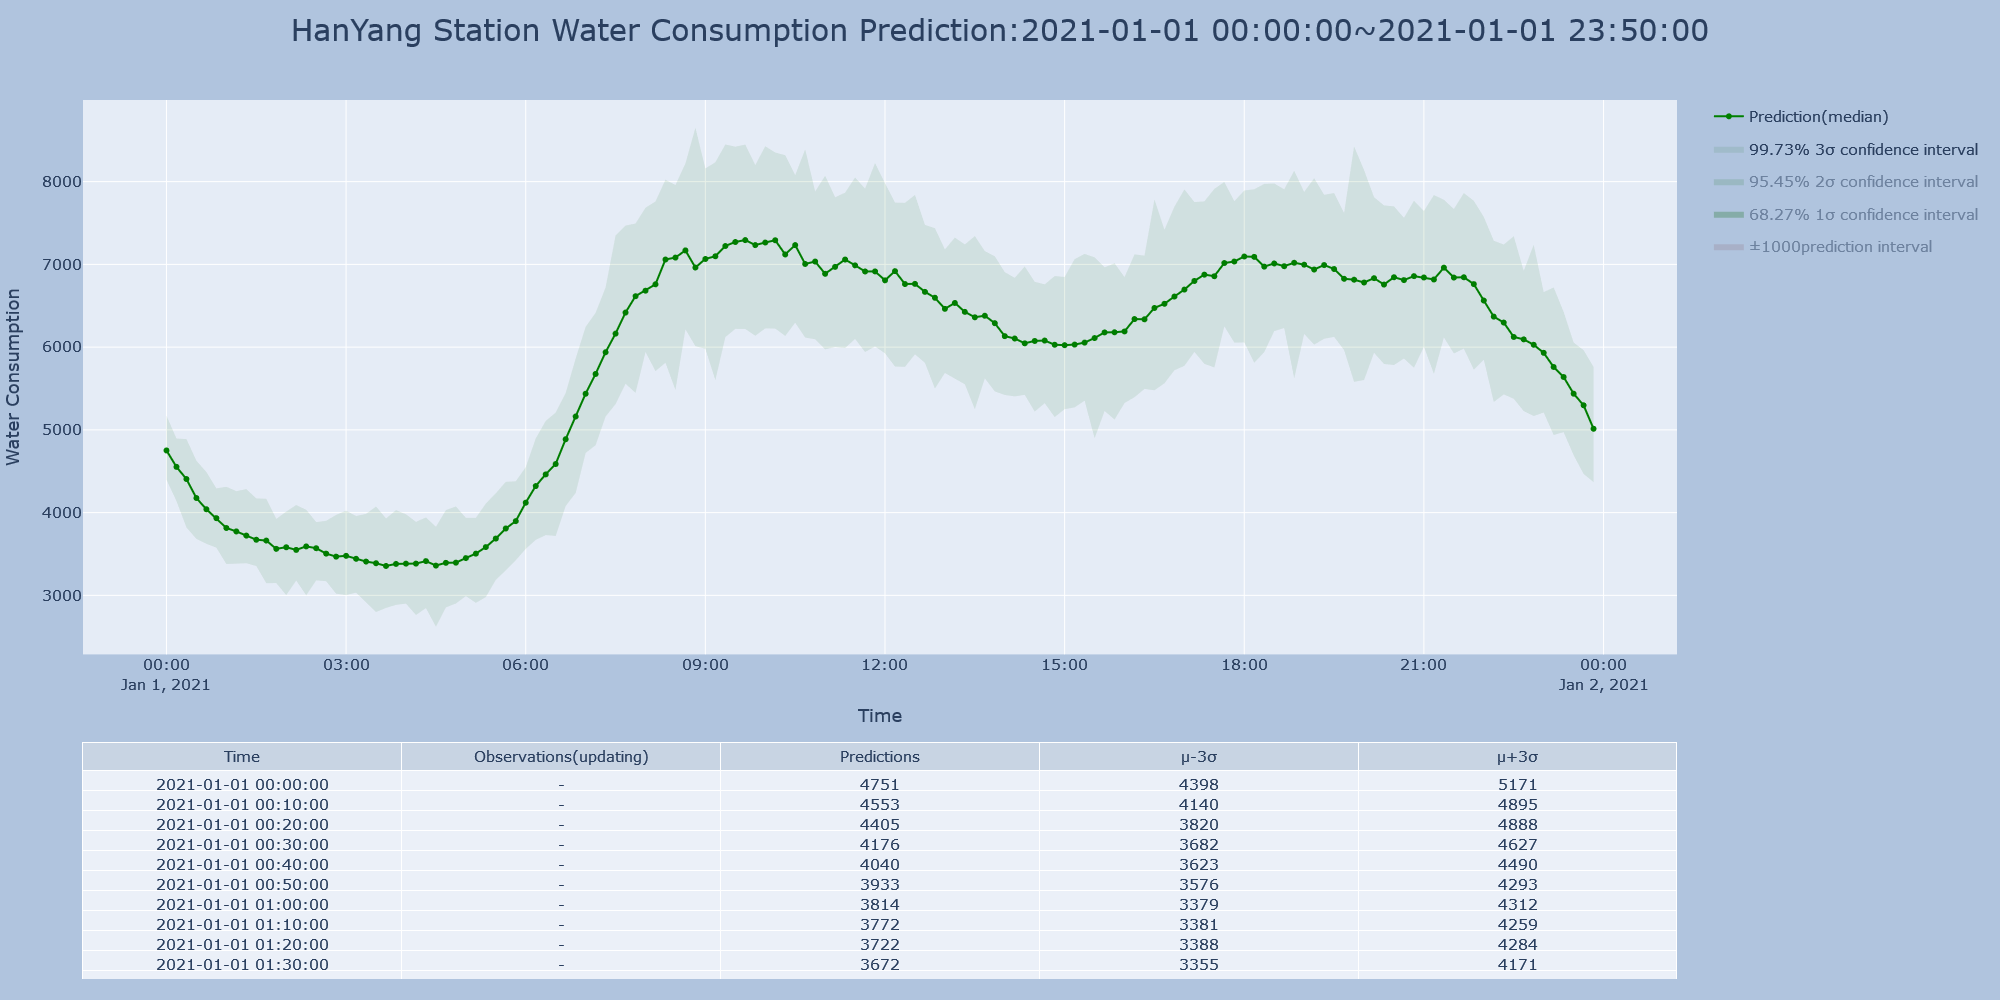

In [10]:
from IPython.display import Image
Image(filename=f'Fig\\{model_name}_unknown.png') 